# Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from collections import defaultdict
from tqdm import tqdm
import json

In [21]:
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow import keras
from tensorflow.keras import layers

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Load Data

In [22]:
import pandas as pd

df = pd.read_csv('../../dataset/weighted_score_above_08.csv')

df.head()

/var/folders/sr/kk6cvpy92zvfzcj5gr5l6c6h0000gn/T/ipykernel_31425/410107815.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../dataset/weighted_score_above_08.csv')


,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,1696305457,...,1,99,2,0.889438,0,1,0,0,1,NaN
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,1696096555,...,1,122,8,0.914834,0,1,0,0,1,NaN
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,1697630734,...,1,599,20,0.968375,3,1,0,0,1,NaN
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,1698261011,...,1,59,12,0.826206,0,0,0,0,1,NaN
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,1697810991,...,1,128,24,0.853612,0,1,0,0,1,NaN


In [23]:
with open('../combined_df.json', 'r') as f:
    sample_data = [json.loads(line) for line in f]

In [24]:
valid_appids = {entry['appid'] for entry in sample_data}

df = df[df['appid'].isin(valid_appids)]

df_games = df[['appid', 'game']]
df_games = df_games.drop_duplicates(subset='appid')

appid2game = df_games.set_index('appid')['game'].to_dict()
game2appid = df_games.set_index('game')['appid'].to_dict()

del df_games

df = df[['appid', 'author_steamid', 'voted_up']]
df.rename(columns={'appid': 'movieId', 'author_steamid': 'userId', 'voted_up': 'rating'}, inplace=True)

In [25]:
item_id_to_genres = {entry['appid']: entry['genre'] for entry in sample_data}

In [7]:
# df.reset_index(drop=True, inplace=True)

In [8]:
# N_DISPLAY = 30
# has_no_genre_count = 0
# for i, item_id in enumerate(df['item_id'].unique()):
#     genres = item_id_to_genres.get(item_id, [])
#     if not genres:
#         has_no_genre_count += 1
#         continue
# print(f"Number of games without genres: {has_no_genre_count}")

In [9]:
# nan_count = df['rating'].isna().sum()
# print(f"Number of NaN values in 'rating': {nan_count}")

In [10]:
sample_data[0]

{'appid': 550, 'game': 'Left 4 Dead 2', 'genre': ['Action']}

In [11]:
# Create a DataFrame from sample_data
movies_data_clean = pd.DataFrame(sample_data)

# Rename columns for clarity
movies_data_clean.rename(columns={'game': 'title'}, inplace=True)

# Convert the 'genre' list into a pipe-separated string
movies_data_clean['genre'] = movies_data_clean['genre'].apply(lambda x: '|'.join(x) if isinstance(x, list) else '')

# Select only the required columns
movies_data_clean = movies_data_clean[['appid', 'title', 'genre']]
movies_data_clean.rename(columns={'appid': 'movieId'}, inplace=True)
movies_data_clean.rename(columns={'genre': 'genres'}, inplace=True)

movies_data_clean.head()

,movieId,title,genres
0,550,Left 4 Dead 2,Action
1,644560,Mirror,Adventure|Indie|RPG
2,264710,Subnautica,Adventure|Indie
3,294100,RimWorld,Indie|Simulation|Strategy
4,413150,Stardew Valley,Indie|RPG|Simulation


# Validation Methodology

In [279]:
# def leave_one_out_split(interactions_dict):
#     train_interactions = {}
#     test_interactions = {}

#     for user, items in interactions_dict.items():
#         if len(items) < 2:
#             continue  # already filtered but double check
#         train_interactions[user] = items[:-1]
#         test_interactions[user] = [items[-1]]  # last one is held out

#     return train_interactions, test_interactions

def leave_one_out_split(interactions_dict):
    train, test = {}, {}
    for user, items in interactions_dict.items():
        if len(items) < 2:
            continue
        train[user] = items[:-1]
        test[user] = [items[-1]]  # still just the last one
    return train, test




# Two Tower

### Create Item Train Feature Vectors

In [142]:
movie_features_data = movies_data_clean.copy()

In [429]:
movie_features_data.head()

,movieId,title,genres
0,934710,英语杀,Casual|Free To Play|Indie|RPG|Strategy|Account...
1,953610,HOT GIRLS VR,Action|Adventure|Casual|Free to Play|Indie|Mas...
2,919280,MovieMator Video Editor,Accounting|Animation & Modeling|Audio Producti...
3,1052500,御龙在天-平衡国战版,Action|Adventure|Casual|Free To Play|Indie|Mas...
4,1242700,墲人之境：探索,Action|Adventure|Casual|Indie|Massively Multip...


In [144]:
movies_data_clean.shape

(27262, 3)

In [145]:
movies_data_clean.loc[:, 'genre_count'] = movies_data_clean['genres'].str.count(r'\|') + 1

movies_data_clean = (
    movies_data_clean
    .sort_values('genre_count', ascending=False)
    .drop_duplicates('title', keep='first')
    .drop(columns='genre_count')
    .reset_index(drop=True)
)

In [146]:
movies_data_clean.shape

(27262, 3)

In [147]:
movies_data_clean['movieId'].nunique()

27262

#### Read Movie Ratings Data

In [676]:
ratings_data = df.copy()

In [677]:
MIN_NUM_USER_RATINGS = 5
MIN_NUM_MOVIE_RATINGS = 10
user_rating_counts = ratings_data.groupby('userId')['movieId'].count()
eligible_users = user_rating_counts[user_rating_counts >= MIN_NUM_USER_RATINGS].index

movie_rating_counts = ratings_data.groupby('movieId')['userId'].count()
eligible_movies = movie_rating_counts[movie_rating_counts >= MIN_NUM_MOVIE_RATINGS].index

ratings_data = ratings_data[
    ratings_data['userId'].isin(eligible_users) &
    ratings_data['movieId'].isin(eligible_movies)
].copy()

In [678]:
movies_data_clean = movies_data_clean[
    movies_data_clean['movieId'].isin(eligible_movies)
].copy()

In [679]:
len(ratings_data)

53246

In [680]:
ratings_data.head()

,movieId,userId,rating
11,10,76561198340297552,1
26,10,76561198276634938,1
35,10,76561198833514439,1
40,10,76561198035002318,1
44,10,76561199222615786,1


In [681]:
ratings_data['rating'].min()

np.int64(0)

In [682]:
ratings_data.shape

(53246, 3)

In [683]:
ratings_data['movieId'].nunique()

5368

In [684]:
movie_ratings_data = (
    movies_data_clean.join(ratings_data[['userId', 'movieId', 'rating']].set_index('movieId'), on='movieId', how='inner')
    [['userId', 'movieId', 'title', 'rating', 'genres']]
).sort_values(['userId', 'movieId']).reset_index(drop=True)

In [685]:
user_rating_counts = movie_ratings_data.groupby('userId')['movieId'].count()
eligible_users = user_rating_counts[user_rating_counts > 1].index

movie_rating_counts = movie_ratings_data.groupby('movieId')['userId'].count()
eligible_movies = movie_rating_counts[movie_rating_counts > 1].index

movie_ratings_data = movie_ratings_data[
    movie_ratings_data['userId'].isin(eligible_users) &
    movie_ratings_data['movieId'].isin(eligible_movies)
].copy()


In [686]:
movie_ratings_data.head()

,userId,movieId,title,rating,genres
0,76561197960279927,1840,Source Filmmaker,1,Animation & Modeling|Video Production
1,76561197960279927,4000,Garry's Mod,1,Indie|Simulation
2,76561197960279927,219150,Hotline Miami,1,Action|Indie
3,76561197960279927,252490,Rust,1,Action|Adventure|Indie|Massively Multiplayer|RPG
4,76561197960279927,546560,Half-Life: Alyx,1,Action|Adventure


In [687]:
movie_ratings_data.shape

(52267, 5)

In [688]:
movie_ratings_data['movieId'].nunique()

4594

In [689]:
movie_ratings_data['userId'].nunique()

5639

#### Create Movie Meta Data

In [690]:
movie_meta_data = (
    movie_ratings_data[['movieId', 'title', 'genres']]
      .drop_duplicates(subset='movieId')
)

In [691]:
movie_meta_data.head()

,movieId,title,genres
0,1840,Source Filmmaker,Animation & Modeling|Video Production
1,4000,Garry's Mod,Indie|Simulation
2,219150,Hotline Miami,Action|Indie
3,252490,Rust,Action|Adventure|Indie|Massively Multiplayer|RPG
4,546560,Half-Life: Alyx,Action|Adventure


### Explore Movies

In [692]:
grouped_movie_data = (
    movie_ratings_data.groupby(['movieId', 'title', 'genres']).agg(
        rating_count=('rating', 'count'),
        rating_mean=('rating', 'mean'),
    ).reset_index()
)[['movieId', 'rating_count', 'rating_mean', 'title', 'genres']]
grouped_movie_data.columns = ['movie_id', 'num_ratings', 'average_rating', 'title', 'genres']
grouped_movie_data['average_rating'] = np.round(grouped_movie_data['average_rating'], 1)
grouped_movie_data.head()

,movie_id,num_ratings,average_rating,title,genres
0,10,70,1.0,Counter-Strike,Action
1,20,6,1.0,Team Fortress Classic,Action
2,30,5,1.0,Day of Defeat,Action
3,40,3,1.0,Deathmatch Classic,Action
4,50,12,1.0,Half-Life: Opposing Force,Action


In [693]:
grouped_movie_data.sort_values(by=['num_ratings'], ascending=False)

,movie_id,num_ratings,average_rating,title,genres
945,292030,286,1.0,The Witcher 3: Wild Hunt,RPG
3321,1174180,214,1.0,Red Dead Redemption 2,Action|Adventure
1500,413150,187,1.0,Stardew Valley,Indie|RPG|Simulation
20,550,179,1.0,Left 4 Dead 2,Action
23,730,176,0.9,Counter-Strike 2,Action|Free To Play
...,...,...,...,...,...
3466,1235733,1,1.0,The Sims™ 4 Seasons,Simulação
376,201271,1,1.0,A Total War Saga: FALL OF THE SAMURAI,Strategy
3087,1082710,1,1.0,Bug Fables: The Everlasting Sapling,Action|Adventure|Indie|RPG
3747,1368130,1,0.0,Park Beyond,Casual|Simulation|Strategy


### Explore Genres

In [694]:
movie_ratings_data_genres = movie_ratings_data.assign(genres = movie_ratings_data['genres'].str.split('|'))
movie_ratings_data_exploded = movie_ratings_data_genres.explode('genres').rename(columns={'genres': 'genre'})

In [695]:
MIN_GENRE_COUNT = 5

# Count the number of movies per genre
genre_counts = movie_ratings_data_exploded['genre'].value_counts()

# Filter genres with count >= MIN_GENRE_COUNT
valid_genres = genre_counts[genre_counts >= MIN_GENRE_COUNT].index

# Remove invalid genres from the genre list
movie_ratings_data_exploded = movie_ratings_data_exploded[
    movie_ratings_data_exploded['genre'].isin(valid_genres)
].copy()

movie_ratings_data_exploded.head()

,userId,movieId,title,rating,genre
0,76561197960279927,1840,Source Filmmaker,1,Animation & Modeling
0,76561197960279927,1840,Source Filmmaker,1,Video Production
1,76561197960279927,4000,Garry's Mod,1,Indie
1,76561197960279927,4000,Garry's Mod,1,Simulation
2,76561197960279927,219150,Hotline Miami,1,Action


In [696]:
movie_ratings_data_exploded.head()

,userId,movieId,title,rating,genre
0,76561197960279927,1840,Source Filmmaker,1,Animation & Modeling
0,76561197960279927,1840,Source Filmmaker,1,Video Production
1,76561197960279927,4000,Garry's Mod,1,Indie
1,76561197960279927,4000,Garry's Mod,1,Simulation
2,76561197960279927,219150,Hotline Miami,1,Action


In [697]:
grouped_genre_data = (
    movie_ratings_data_exploded.groupby(['genre'])
    .agg(
        movie_count=('movieId', 'nunique'),
        rating_mean=('rating', 'mean'),
        rating_count=('rating', 'count'),
    )
    .reset_index()
)
grouped_genre_data.columns = ['genre', 'num_movies', 'average_rating_per_genre', 'num_ratings_per_genre']
grouped_genre_data['average_rating_per_genre'] = np.round(
    grouped_genre_data['average_rating_per_genre'], 1
)

In [698]:
grouped_genre_data.sort_values('num_ratings_per_genre', ascending=False)

,genre,num_movies,average_rating_per_genre,num_ratings_per_genre
0,Action,2170,0.9,29326
1,Adventure,1864,0.9,23714
18,Indie,2196,1.0,21248
29,RPG,1269,0.9,14182
35,Simulation,1159,0.9,10104
...,...,...,...,...
26,Online PvP,1,1.0,5
24,Niezależne,1,0.8,5
50,Strategia,1,0.8,5
10,Estrategia,1,0.6,5


### Create Item Feature Vectors

In [699]:
grouped_movie_ratings_data = (
    movie_ratings_data
    .groupby(['movieId', 'title', 'genres'], as_index=False)
    .agg(item_average_rating = ('rating', 'mean'))
)

In [700]:
grouped_movie_ratings_data.head()

,movieId,title,genres,item_average_rating
0,10,Counter-Strike,Action,1.0
1,20,Team Fortress Classic,Action,1.0
2,30,Day of Defeat,Action,1.0
3,40,Deathmatch Classic,Action,1.0
4,50,Half-Life: Opposing Force,Action,1.0


In [701]:
# Define the constant threshold
CONSTANT = 1000  # Replace with your desired threshold

# Count the number of games per genre
genre_counts = grouped_movie_ratings_data['genres'].str.split('|').explode().value_counts()

# Filter genres with count >= CONSTANT
valid_genres = genre_counts[genre_counts >= CONSTANT].index

# Filter the genres in the DataFrame
genre_dummies = grouped_movie_ratings_data['genres'].str.get_dummies(sep='|')[valid_genres]

In [702]:
item_genre_dummies = genre_dummies.add_prefix('item_')

In [703]:
item_features = pd.concat([
    grouped_movie_ratings_data[['movieId', 'item_average_rating']],
    item_genre_dummies
], axis=1)

In [704]:
item_features.head()

,movieId,item_average_rating,item_Indie,item_Action,item_Adventure,item_RPG,item_Simulation,item_Strategy
0,10,1.0,0,1,0,0,0,0
1,20,1.0,0,1,0,0,0,0
2,30,1.0,0,1,0,0,0,0
3,40,1.0,0,1,0,0,0,0
4,50,1.0,0,1,0,0,0,0


In [705]:
item_features.shape

(4594, 8)

### Create User Feature Vectors

In [706]:
movie_ratings_data.head()

,userId,movieId,title,rating,genres
0,76561197960279927,1840,Source Filmmaker,1,Animation & Modeling|Video Production
1,76561197960279927,4000,Garry's Mod,1,Indie|Simulation
2,76561197960279927,219150,Hotline Miami,1,Action|Indie
3,76561197960279927,252490,Rust,1,Action|Adventure|Indie|Massively Multiplayer|RPG
4,76561197960279927,546560,Half-Life: Alyx,1,Action|Adventure


In [707]:
movie_ratings_genre_exploded = (
    movie_ratings_data
    .assign(genres = movie_ratings_data['genres'].str.split('|'))
    .explode('genres')
    .rename(columns={'genres':'genre'})
)

In [708]:
MIN_GENRE_COUNT = 1000

# Count the number of games per genre
genre_counts = movie_ratings_genre_exploded['genre'].value_counts()

# Filter genres with count >= MIN_GENRE_COUNT
valid_genres = genre_counts[genre_counts >= MIN_GENRE_COUNT].index

# Remove invalid genres from the genre list
movie_ratings_genre_exploded = movie_ratings_genre_exploded[
    movie_ratings_genre_exploded['genre'].isin(valid_genres)
].copy()

In [709]:
user_stats = (
    movie_ratings_genre_exploded
    .groupby('userId', as_index=True)['rating']
    .agg(
        user_rating_count = 'count',
        user_average_rating = 'mean'
    )
)

In [710]:
user_genres = (
    movie_ratings_genre_exploded
    .groupby(['userId', 'genre'], as_index=True)['rating']
    .mean()
    .unstack('genre') 
    .add_prefix('user_')
)

In [711]:
user_features = (
    user_stats
    .join(user_genres)
    .reset_index()  
)

In [712]:
user_features = user_features.fillna(0)

In [713]:
user_features.head()

,userId,user_rating_count,user_average_rating,user_Action,user_Adventure,user_Casual,user_Early Access,user_Free To Play,user_Free to Play,user_Indie,user_Massively Multiplayer,user_RPG,user_Racing,user_Simulation,user_Sports,user_Strategy
0,76561197960279927,14,1.000000,1.00,1.000000,0.0,1.0,0.0,0.0,1.0,1.0,1.000000,0.0,1.0,0.0,0.0
1,76561197960302579,43,1.000000,1.00,1.000000,1.0,0.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.0,1.0
2,76561197960306154,6,1.000000,1.00,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0
3,76561197960332616,28,0.857143,0.75,0.833333,0.0,1.0,0.0,0.0,1.0,0.0,0.666667,0.0,1.0,0.0,1.0
4,76561197960351126,29,1.000000,1.00,1.000000,1.0,0.0,0.0,0.0,1.0,1.0,1.000000,0.0,1.0,1.0,1.0


In [714]:
user_features['userId'].nunique()

5638

In [715]:
combined_features_df = (
    movie_ratings_data
      .loc[:, ['userId', 'movieId', 'rating']]
      .merge(user_features, on='userId')
      .merge(item_features, on='movieId')
)

In [716]:
combined_features_df.shape

(52266, 25)

In [717]:
list(combined_features_df.columns)

['userId',
 'movieId',
 'rating',
 'user_rating_count',
 'user_average_rating',
 'user_Action',
 'user_Adventure',
 'user_Casual',
 'user_Early Access',
 'user_Free To Play',
 'user_Free to Play',
 'user_Indie',
 'user_Massively Multiplayer',
 'user_RPG',
 'user_Racing',
 'user_Simulation',
 'user_Sports',
 'user_Strategy',
 'item_average_rating',
 'item_Indie',
 'item_Action',
 'item_Adventure',
 'item_RPG',
 'item_Simulation',
 'item_Strategy']

In [718]:
# def leave_one_out_split_df(df):
#     df = df.sort_values(['userId', 'movieId'])
#     train_rows = []
#     test_rows = []
#     for user_id, group in df.groupby('userId'):
#         if len(group) < 2:
#             continue
#         test_rows.append(group.iloc[-1])
#         train_rows.append(group.iloc[:-1])
#     train_df = pd.concat(train_rows).reset_index(drop=True)
#     test_df = pd.DataFrame(test_rows).reset_index(drop=True)
#     return train_df, test_df

In [719]:
import random

def leave_one_out_split_df(df):
    df = df.sort_values(['userId', 'movieId'])
    train_rows = []
    test_rows = []
    for user_id, group in df.groupby('userId'):
        if len(group) < 2:
            continue
        random_index = random.randint(0, len(group) - 1)
        test_rows.append(group.iloc[random_index])
        train_rows.append(group.drop(group.index[random_index]))
    train_df = pd.concat(train_rows).reset_index(drop=True)
    test_df = pd.DataFrame(test_rows).reset_index(drop=True)
    return train_df, test_df

In [720]:
train_df, test_df = leave_one_out_split_df(combined_features_df)

#### Train Two-Tower System

In [721]:
# train_df, test_df = train_test_split(combined_features_df, test_size=0.2, random_state=42)

In [722]:
train_df.head()

,userId,movieId,rating,user_rating_count,user_average_rating,user_Action,user_Adventure,user_Casual,user_Early Access,user_Free To Play,...,user_Simulation,user_Sports,user_Strategy,item_average_rating,item_Indie,item_Action,item_Adventure,item_RPG,item_Simulation,item_Strategy
0,76561197960279927,1840,1,14,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.000000,0,0,0,0,0,0
1,76561197960279927,4000,1,14,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.000000,1,0,0,0,1,0
2,76561197960279927,252490,1,14,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.954545,1,1,1,1,0,0
3,76561197960279927,546560,1,14,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.000000,0,1,1,0,0,0
4,76561197960279927,555160,1,14,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.000000,1,1,0,0,0,0


In [723]:
test_df.head()

,userId,movieId,rating,user_rating_count,user_average_rating,user_Action,user_Adventure,user_Casual,user_Early Access,user_Free To Play,...,user_Simulation,user_Sports,user_Strategy,item_average_rating,item_Indie,item_Action,item_Adventure,item_RPG,item_Simulation,item_Strategy
0,7.656120e+16,219150.0,1.0,14.0,1.000000,1.00,1.000000,0.0,1.0,0.0,...,1.0,0.0,0.0,1.000000,1.0,1.0,0.0,0.0,0.0,0.0
1,7.656120e+16,261470.0,1.0,43.0,1.000000,1.00,1.000000,1.0,0.0,1.0,...,1.0,0.0,1.0,1.000000,0.0,0.0,0.0,0.0,1.0,1.0
2,7.656120e+16,675010.0,1.0,6.0,1.000000,1.00,1.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.823529,0.0,0.0,0.0,0.0,1.0,0.0
3,7.656120e+16,846770.0,1.0,28.0,0.857143,0.75,0.833333,0.0,1.0,0.0,...,1.0,0.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.0
4,7.656120e+16,1334590.0,1.0,29.0,1.000000,1.00,1.000000,1.0,0.0,0.0,...,1.0,1.0,1.0,0.900000,1.0,1.0,1.0,1.0,1.0,0.0


In [724]:
user_continuous = ['user_rating_count', 'user_average_rating'] + [c for c in user_features.columns if c not in ['userId', 'user_rating_count', 'user_average_rating']]

In [725]:
item_continuous = ['item_average_rating']
item_genres = [c for c in item_features.columns if c not in ['movieId', 'item_average_rating']]

In [726]:
user_standardizer = StandardScaler()
item_standardizer = StandardScaler()

In [727]:
train_df[user_continuous] = user_standardizer.fit_transform(train_df[user_continuous])
train_df[item_continuous] = item_standardizer.fit_transform(train_df[item_continuous])

In [728]:
test_df[user_continuous] = user_standardizer.transform(test_df[user_continuous])
test_df[item_continuous] = item_standardizer.transform(test_df[item_continuous])

In [729]:
X_train_user = train_df[user_continuous].to_numpy()
X_train_item = train_df[item_continuous + item_genres].to_numpy()
y_train = train_df['rating'].to_numpy()

In [730]:
X_train_user.shape

(46628, 15)

In [731]:
X_train_item.shape

(46628, 7)

In [732]:
X_test_user = test_df[user_continuous].to_numpy()
X_test_item = test_df[item_continuous + item_genres].to_numpy()
y_test = test_df['rating'].to_numpy()

In [733]:
user_input = keras.Input(shape=(X_train_user.shape[1],), name='user_input')
item_input = keras.Input(shape=(X_train_item.shape[1],), name='item_input')

In [734]:
# user tower: 256 → 128 → 32

u = layers.Dense(512, activation='relu')(user_input)
u = layers.Dense(256, activation='relu')(user_input)
u = layers.Dense(128, activation='relu')(u)
u = layers.Dense(32,  activation='relu')(u)

In [735]:
# item tower: 256 → 128 → 32
i = layers.Dense(512, activation='relu')(item_input)
i = layers.Dense(256, activation='relu')(item_input)
i = layers.Dense(128, activation='relu')(i)
i = layers.Dense(32,  activation='relu')(i)

In [736]:
dot = layers.Dot(axes=1)([u, i])
output = layers.Activation('sigmoid')(dot)

In [737]:
model = keras.Model(inputs=[user_input, item_input], outputs=output)

In [738]:
tf.random.set_seed(1)
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',  # Use binary_crossentropy if targets are 0/1
    metrics=['mse'],
)

#### Train the model

In [739]:
from tensorflow.keras.callbacks import EarlyStopping

In [740]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    x = [X_train_user, X_train_item],
    y = y_train,
    batch_size=8,
    epochs=30,
    validation_data=([X_test_user, X_test_item], y_test),
    verbose=2
)

Epoch 1/30
5829/5829 - 6s - 966us/step - loss: 0.1138 - mse: 0.0351 - val_loss: 0.1135 - val_mse: 0.0374
Epoch 2/30
5829/5829 - 5s - 830us/step - loss: 0.1032 - mse: 0.0326 - val_loss: 0.1062 - val_mse: 0.0355
Epoch 3/30
5829/5829 - 5s - 800us/step - loss: 0.0985 - mse: 0.0316 - val_loss: 0.1056 - val_mse: 0.0349
Epoch 4/30
5829/5829 - 5s - 798us/step - loss: 0.0964 - mse: 0.0312 - val_loss: 0.1012 - val_mse: 0.0341
Epoch 5/30
5829/5829 - 5s - 801us/step - loss: 0.0937 - mse: 0.0308 - val_loss: 0.1006 - val_mse: 0.0339
Epoch 6/30
5829/5829 - 5s - 853us/step - loss: 0.0935 - mse: 0.0304 - val_loss: 0.0998 - val_mse: 0.0334
Epoch 7/30
5829/5829 - 5s - 803us/step - loss: 0.0918 - mse: 0.0302 - val_loss: 0.1007 - val_mse: 0.0340
Epoch 8/30
5829/5829 - 5s - 822us/step - loss: 0.0908 - mse: 0.0300 - val_loss: 0.1017 - val_mse: 0.0339
Epoch 9/30
5829/5829 - 5s - 799us/step - loss: 0.0888 - mse: 0.0296 - val_loss: 0.1017 - val_mse: 0.0335
Epoch 10/30
5829/5829 - 5s - 805us/step - loss: 0.0885 

In [ ]:
# class_weight = {0: 1.5, 1: 1.0}  # Adjust the weights as needed

# history = model.fit(
#     x=[X_train_user, X_train_item],
#     y=y_train,
#     batch_size=128,
#     epochs=30,
#     validation_data=([X_test_user, X_test_item], y_test),
#     verbose=2,
#     class_weight=class_weight
# )

Epoch 1/30
853/853 - 2s - 2ms/step - loss: 0.1794 - mse: 0.0437 - val_loss: 0.1870 - val_mse: 0.0557
Epoch 2/30
853/853 - 2s - 2ms/step - loss: 0.2048 - mse: 0.0460 - val_loss: 0.1812 - val_mse: 0.0536
Epoch 3/30
853/853 - 2s - 2ms/step - loss: 0.2453 - mse: 0.0607 - val_loss: 0.1679 - val_mse: 0.0540
Epoch 4/30
853/853 - 1s - 2ms/step - loss: 0.1908 - mse: 0.0468 - val_loss: 0.1704 - val_mse: 0.0587
Epoch 5/30
853/853 - 1s - 2ms/step - loss: 0.1827 - mse: 0.0463 - val_loss: 0.1563 - val_mse: 0.0524
Epoch 6/30
853/853 - 1s - 2ms/step - loss: 0.1788 - mse: 0.0447 - val_loss: 0.1564 - val_mse: 0.0519
Epoch 7/30
853/853 - 1s - 2ms/step - loss: 0.1747 - mse: 0.0441 - val_loss: 0.1564 - val_mse: 0.0523
Epoch 8/30
853/853 - 1s - 2ms/step - loss: 0.2307 - mse: 0.0481 - val_loss: 0.2499 - val_mse: 0.0868
Epoch 9/30
853/853 - 1s - 2ms/step - loss: 0.2343 - mse: 0.0583 - val_loss: 0.5830 - val_mse: 0.0589
Epoch 10/30
853/853 - 1s - 2ms/step - loss: 0.1912 - mse: 0.0466 - val_loss: 0.4545 - val_m

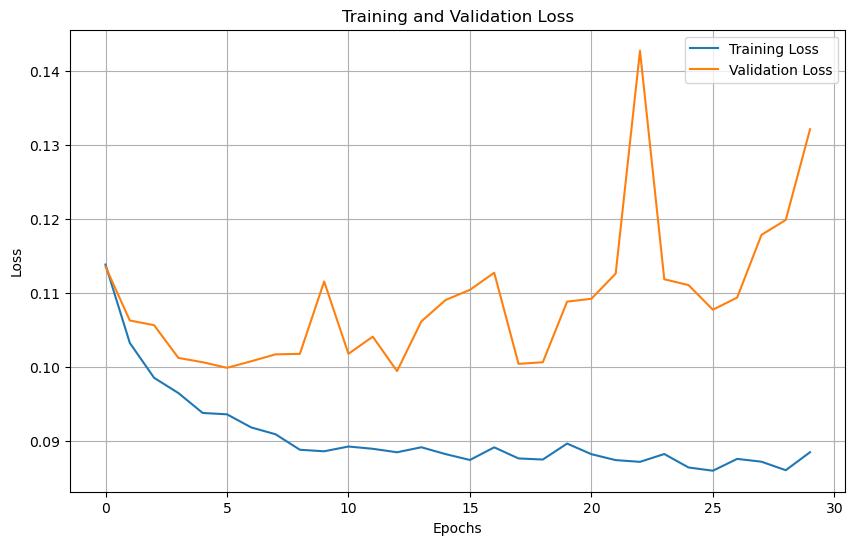

In [741]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Compare predictions for an existing user

In [742]:
user_movie_counts = df.groupby('userId')['movieId'].count()
first_user = user_movie_counts[user_movie_counts > 5].index[0]
print(first_user)

76561197960279927


In [743]:
user_id = 76561197960279927

In [744]:
test_df.head()

,userId,movieId,rating,user_rating_count,user_average_rating,user_Action,user_Adventure,user_Casual,user_Early Access,user_Free To Play,...,user_Simulation,user_Sports,user_Strategy,item_average_rating,item_Indie,item_Action,item_Adventure,item_RPG,item_Simulation,item_Strategy
0,7.656120e+16,219150.0,1.0,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,-1.563825,0.446134,1.0,1.0,0.0,0.0,0.0,0.0
1,7.656120e+16,261470.0,1.0,-0.242650,0.539295,0.460911,0.429917,0.744549,-0.845674,1.423699,...,0.634949,-0.573152,0.704646,0.446134,0.0,0.0,0.0,0.0,1.0,1.0
2,7.656120e+16,675010.0,1.0,-0.506301,0.539295,0.460911,0.429917,-1.462283,-0.845674,-0.732680,...,0.634949,-0.573152,-1.563825,-0.701960,0.0,0.0,0.0,0.0,1.0,0.0
3,7.656120e+16,846770.0,1.0,-0.349535,-0.565016,-0.731775,-0.288287,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,0.704646,0.446134,1.0,1.0,1.0,1.0,1.0,0.0
4,7.656120e+16,1334590.0,1.0,-0.342410,0.539295,0.460911,0.429917,0.744549,-0.845674,-0.732680,...,0.634949,1.813053,0.704646,-0.204453,1.0,1.0,1.0,1.0,1.0,0.0


In [745]:
user_test_df = test_df[test_df['userId'] == user_id].copy()

In [746]:
user_test_df.head()

,userId,movieId,rating,user_rating_count,user_average_rating,user_Action,user_Adventure,user_Casual,user_Early Access,user_Free To Play,...,user_Simulation,user_Sports,user_Strategy,item_average_rating,item_Indie,item_Action,item_Adventure,item_RPG,item_Simulation,item_Strategy
0,7.656120e+16,219150.0,1.0,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,-0.73268,...,0.634949,-0.573152,-1.563825,0.446134,1.0,1.0,0.0,0.0,0.0,0.0


In [747]:
X_user = user_test_df[user_continuous].to_numpy()
X_item = user_test_df[item_continuous + item_genres].to_numpy()

In [748]:
y_true = user_test_df['rating'].to_numpy()

In [749]:
y_pred = model.predict([X_user, X_item]).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [750]:
user_test_df.insert(3, 'predictions', y_pred)

In [751]:
user_test_df.head()

,userId,movieId,rating,predictions,user_rating_count,user_average_rating,user_Action,user_Adventure,user_Casual,user_Early Access,...,user_Simulation,user_Sports,user_Strategy,item_average_rating,item_Indie,item_Action,item_Adventure,item_RPG,item_Simulation,item_Strategy
0,7.656120e+16,219150.0,1.0,1.0,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,...,0.634949,-0.573152,-1.563825,0.446134,1.0,1.0,0.0,0.0,0.0,0.0


In [752]:
rmse = root_mean_squared_error(y_true, y_pred)
print(rmse)

0.0


### Make predictions for a new user

In [753]:
list(user_test_df.columns)

['userId',
 'movieId',
 'rating',
 'predictions',
 'user_rating_count',
 'user_average_rating',
 'user_Action',
 'user_Adventure',
 'user_Casual',
 'user_Early Access',
 'user_Free To Play',
 'user_Free to Play',
 'user_Indie',
 'user_Massively Multiplayer',
 'user_RPG',
 'user_Racing',
 'user_Simulation',
 'user_Sports',
 'user_Strategy',
 'item_average_rating',
 'item_Indie',
 'item_Action',
 'item_Adventure',
 'item_RPG',
 'item_Simulation',
 'item_Strategy']

In [754]:
# new_user = {
#     'user_rating_count'   : 3,
#     'user_average_rating' : 0.0,
#     'user_Action'         : 0.0,
#     'user_Adventure'      : 5.0,
#     'user_Animation'      : 0.0,
#     'user_Children'       : 0.0,
#     'user_Comedy'         : 0.0,
#     'user_Crime'          : 0.0,
#     'user_Documentary'    : 0.0,
#     'user_Drama'          : 0.0,
#     'user_Fantasy'        : 5.0,
#     'user_Horror'         : 0.0,
#     'user_Mystery'        : 0.0,
#     'user_Romance'        : 0.0,
#     'user_Sci-Fi'         : 0.0,
#     'user_Thriller'       : 0.0,
# }

new_user = {key: 0.0 for key in user_features.columns if key not in ['userId']}
new_user['user_Simulation'] = 5.0

In [755]:
new_user_df = pd.DataFrame([new_user])

In [756]:
new_user_df[user_continuous] = user_standardizer.transform(new_user_df[user_continuous])

In [757]:
X_new_user = new_user_df[user_continuous].to_numpy() 

In [758]:
X_new_user.shape

(1, 15)

#### Get the user embedding vector

In [759]:
user_model = keras.Model(
    inputs = user_input,
    outputs = u,
    name = "user_embedding_model"
)

#### Get the item embedding vector

In [760]:
item_model = keras.Model(
    inputs = item_input,
    outputs = i,
    name = "item_embedding_model"
)

In [761]:
user_embedding = user_model.predict(X_new_user)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [762]:
user_embedding.shape

(1, 32)

In [763]:
item_features_copy = item_features.copy()

In [764]:
item_features_copy[item_continuous] = item_standardizer.transform(item_features_copy[item_continuous])

In [765]:
X_all_items = item_features_copy[item_continuous + item_genres].to_numpy()

In [766]:
item_embeddings = item_model.predict(X_all_items, batch_size=512)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [767]:
item_embeddings.shape

(4594, 32)

In [768]:
scores = item_embeddings.dot(user_embedding[0]) 

In [769]:
len(scores)

4594

In [770]:
top_k_indices = np.argsort(scores)[-10:][::-1]
top_k_movieIds = item_features.iloc[top_k_indices]['movieId']

In [771]:
recommendations = (
    pd.DataFrame({'movieId': top_k_movieIds})
      .merge(movie_meta_data, on='movieId', how='left')
      [['movieId', 'title', 'genres']]
)

In [772]:
recommendations

,movieId,title,genres
0,212010,Galaxy on Fire 2™ Full HD,Action|Indie|Simulation|Strategy
1,736220,Post Scriptum,Action|Indie|Massively Multiplayer|Simulation|...
2,1787820,Mirror Party,Action|Casual|Indie|Simulation|Strategy|Early ...
3,669330,Mechabellum,Action|Indie|Massively Multiplayer|Simulation|...
4,674500,Total Tank Simulator,Action|Indie|Simulation|Strategy
5,247020,"Cook, Serve, Delicious!",Action|Indie|Simulation|Strategy
6,244850,Space Engineers,Action|Indie|Simulation|Strategy
7,1216320,Shieldwall,Action|Casual|Indie|Simulation|Strategy
8,248610,Door Kickers,Action|Indie|Simulation|Strategy
9,2291760,Papa's Freezeria Deluxe,Action|Casual|Indie|Simulation|Strategy


In [789]:
from tqdm import tqdm

def evaluate_recommendations(k, user_model, item_model, train_data, test_data, item_features, item_standardizer, item_continuous, item_genres):
    """
    Evaluate recommendation performance using precision@k, recall@k, f1@k, and map@k.

    Parameters:
        k (int): Number of top recommendations to consider.
        user_model (keras.Model): User embedding model.
        item_model (keras.Model): Item embedding model.
        train_data (pd.DataFrame): Training data containing user-item interactions.
        test_data (pd.DataFrame): Test data containing the hidden liked item for each user.
        item_features (pd.DataFrame): Item features data.
        item_standardizer (StandardScaler): StandardScaler for item features.
        item_continuous (list): List of continuous item feature column names.
        item_genres (list): List of genre feature column names.

    Returns:
        dict: A dictionary containing precision@k, recall@k, f1@k, and map@k.
    """
    # Prepare item embeddings
    item_features_copy = item_features.copy()
    item_features_copy[item_continuous] = item_standardizer.transform(item_features_copy[item_continuous])
    X_all_items = item_features_copy[item_continuous + item_genres].to_numpy()
    item_embeddings = item_model.predict(X_all_items, batch_size=512, verbose=False)

    # Initialize metrics
    precision_at_k = []
    recall_at_k = []
    f1_at_k = []
    average_precision_at_k = []

    # Iterate over each user in the test data
    for user_id in tqdm(test_data['userId'].unique(), desc="Evaluating users"):
        # Get user embedding
        user_train_data = train_data[train_data['userId'] == user_id]
        user_test_data = test_data[test_data['userId'] == user_id]
        if user_test_data.empty or user_train_data.empty:
            continue

        X_user = user_model.predict(user_train_data[user_continuous].to_numpy(), batch_size=512, verbose=False)

        # Compute scores for all items
        scores = item_embeddings.dot(X_user[0])

        # Get top-k recommendations
        top_k_indices = np.argsort(scores)[-k:][::-1]
        top_k_movieIds = item_features.iloc[top_k_indices]['movieId'].values

        # Get the ground truth (hidden liked item)
        ground_truth = set(user_test_data['movieId'].values)

        # Calculate precision@k, recall@k, f1@k, and average precision@k
        recommended_set = set(top_k_movieIds)
        true_positives = len(recommended_set & ground_truth)
        precision = true_positives / k
        recall = true_positives / len(ground_truth)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        average_precision = sum([(i + 1) / (rank + 1) for rank, i in enumerate(top_k_movieIds) if i in ground_truth]) / min(len(ground_truth), k)

        # Append metrics
        precision_at_k.append(precision)
        recall_at_k.append(recall)
        f1_at_k.append(f1)
        average_precision_at_k.append(average_precision)

    # Aggregate metrics
    results = {
        'precision@k': np.mean(precision_at_k),
        'recall@k': np.mean(recall_at_k),
        'f1@k': np.mean(f1_at_k),
        'map@k': np.mean(average_precision_at_k)
    }

    return results

# Example usage:
k = 10
results = evaluate_recommendations(
    k=k,
    user_model=user_model,
    item_model=item_model,
    train_data=train_df,
    test_data=test_df,
    item_features=item_features,
    item_standardizer=item_standardizer,
    item_continuous=item_continuous,
    item_genres=item_genres
)

print(f"Precision@{k}: {results['precision@k']}")
print(f"Recall@{k}: {results['recall@k']}")
print(f"F1@{k}: {results['f1@k']}")
print(f"MAP@{k}: {results['map@k']}")


Evaluating users: 100%|██████████| 5622/5622 [03:14<00:00, 28.86it/s]

Precision@10: 0.00010672358591248667
Recall@10: 0.0010672358591248667
F1@10: 0.00019404288347724845
MAP@10: 191.87373159865155


In [786]:
from tqdm import tqdm

def evaluate_recommendations(k, user_model, item_model, train_data, test_data, item_features, item_standardizer, item_continuous, item_genres):
    """
    Evaluate recommendation performance using precision@k, recall@k, f1@k, and map@k.

    Parameters:
        k (int): Number of top recommendations to consider.
        user_model (keras.Model): User embedding model.
        item_model (keras.Model): Item embedding model.
        train_data (pd.DataFrame): Training data containing user-item interactions.
        test_data (pd.DataFrame): Test data containing the hidden liked item for each user.
        item_features (pd.DataFrame): Item features data.
        item_standardizer (StandardScaler): StandardScaler for item features.
        item_continuous (list): List of continuous item feature column names.
        item_genres (list): List of genre feature column names.

    Returns:
        dict: A dictionary containing precision@k, recall@k, f1@k, and map@k.
    """
    # Prepare item embeddings
    item_features_copy = item_features.copy()
    item_features_copy[item_continuous] = item_standardizer.transform(item_features_copy[item_continuous])
    X_all_items = item_features_copy[item_continuous + item_genres].to_numpy()
    item_embeddings = item_model.predict(X_all_items, batch_size=512, verbose=0)

    # Initialize metrics
    precision_at_k = []
    recall_at_k = []
    f1_at_k = []
    average_precision_at_k = []

    # Iterate over each user in the test data with tqdm
    for user_id in tqdm(test_data['userId'].unique(), desc="Evaluating users"):
        # Get user embedding
        user_train_data = train_data[train_data['userId'] == user_id]
        user_test_data = test_data[test_data['userId'] == user_id]
        if user_test_data.empty or user_train_data.empty:
            continue

        X_user = user_model.predict(user_train_data[item_continuous].to_numpy(), batch_size=512, verbose=0)

        # Compute scores for all items
        scores = item_embeddings.dot(X_user[0])

        # Get top-k recommendations
        top_k_indices = np.argsort(scores)[-k:][::-1]
        top_k_movieIds = item_features.iloc[top_k_indices]['movieId'].values

        # Get the ground truth (hidden liked item)
        ground_truth = set(user_test_data['movieId'].values)

        # Calculate precision@k, recall@k, f1@k, and average precision@k
        recommended_set = set(top_k_movieIds)
        true_positives = len(recommended_set & ground_truth)
        precision = true_positives / k
        recall = true_positives / len(ground_truth)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        average_precision = sum([(i + 1) / (rank + 1) for rank, i in enumerate(top_k_movieIds) if i in ground_truth]) / min(len(ground_truth), k)

        # Append metrics
        precision_at_k.append(precision)
        recall_at_k.append(recall)
        f1_at_k.append(f1)
        average_precision_at_k.append(average_precision)

    # Aggregate metrics
    results = {
        'precision@k': np.mean(precision_at_k),
        'recall@k': np.mean(recall_at_k),
        'f1@k': np.mean(f1_at_k),
        'map@k': np.mean(average_precision_at_k)
    }

    return results


In [ ]:
results = evaluate_recommendations(
    k=k,
    user_model=user_model,
    item_model=item_model,
    train_data=train_df,
    test_data=test_df,
    item_features=item_features,
    item_standardizer=item_standardizer,
    item_continuous=item_continuous,
    item_genres=item_genres
)

print(f"Precision@{k}: {results['precision@k']}")
print(f"Recall@{k}: {results['recall@k']}")
print(f"F1@{k}: {results['f1@k']}")
print(f"MAP@{k}: {results['map@k']}")

Evaluating users: 100%|██████████| 5622/5622 [03:09<00:00, 29.66it/s]

Precision@10: 0.00010672358591248667
Recall@10: 0.0010672358591248667
F1@10: 0.00019404288347724845
MAP@10: 191.87373159865155


In [791]:
from tqdm import tqdm
import random

def evaluate_recommendations_worst(k, user_model, item_model, train_data, test_data, item_features, item_standardizer, item_continuous, item_genres):
    """
    Evaluate recommendation performance using precision@k, recall@k, f1@k, and map@k using random guessing.

    Parameters:
        k (int): Number of top recommendations to consider.
        user_model (keras.Model): User embedding model (not used in random guessing).
        item_model (keras.Model): Item embedding model (not used in random guessing).
        train_data (pd.DataFrame): Training data containing user-item interactions.
        test_data (pd.DataFrame): Test data containing the hidden liked item for each user.
        item_features (pd.DataFrame): Item features data.
        item_standardizer (StandardScaler): StandardScaler for item features (not used in random guessing).
        item_continuous (list): List of continuous item feature column names (not used in random guessing).
        item_genres (list): List of genre feature column names (not used in random guessing).

    Returns:
        dict: A dictionary containing precision@k, recall@k, f1@k, and map@k.
    """

    # Get all unique movieIds
    all_movieIds = item_features['movieId'].values

    # Initialize metrics
    precision_at_k = []
    recall_at_k = []
    f1_at_k = []
    average_precision_at_k = []

    # Iterate over each user in the test data
    for user_id in tqdm(test_data['userId'].unique(), desc="Evaluating users"):
        # Get user test data
        user_test_data = test_data[test_data['userId'] == user_id]
        if user_test_data.empty:
            continue

        # Randomly guess k movieIds
        random_recommendations = random.sample(list(all_movieIds), k)

        # Get the ground truth (hidden liked item)
        ground_truth = set(user_test_data['movieId'].values)

        # Calculate precision@k, recall@k, f1@k, and average precision@k
        recommended_set = set(random_recommendations)
        true_positives = len(recommended_set & ground_truth)
        precision = true_positives / k
        recall = true_positives / len(ground_truth)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        average_precision = sum([(i + 1) / (rank + 1) for rank, i in enumerate(random_recommendations) if i in ground_truth]) / min(len(ground_truth), k)

        # Append metrics
        precision_at_k.append(precision)
        recall_at_k.append(recall)
        f1_at_k.append(f1)
        average_precision_at_k.append(average_precision)

    # Aggregate metrics
    results = {
        'precision@k': np.mean(precision_at_k),
        'recall@k': np.mean(recall_at_k),
        'f1@k': np.mean(f1_at_k),
        'map@k': np.mean(average_precision_at_k)
    }

    return results


results = evaluate_recommendations_worst(
    k=k,
    user_model=user_model,
    item_model=item_model,
    train_data=train_df,
    test_data=test_df,
    item_features=item_features,
    item_standardizer=item_standardizer,
    item_continuous=item_continuous,
    item_genres=item_genres
)

print(f"Precision@{k}: {results['precision@k']}")
print(f"Recall@{k}: {results['recall@k']}")
print(f"F1@{k}: {results['f1@k']}")
print(f"MAP@{k}: {results['map@k']}")

Evaluating users: 100%|██████████| 5622/5622 [00:02<00:00, 2498.32it/s]

Precision@10: 0.0003379580220562078
Recall@10: 0.0033795802205620774
F1@10: 0.0006144691310112869
MAP@10: 467.1443804949941


In [792]:
# Generate user embedding for the target user
user_embedding = user_model.predict(X_new_user)

# Generate item embeddings for all items
item_embeddings = item_model.predict(X_all_items, batch_size=512)

# Compute similarity scores between the user embedding and all item embeddings
scores = item_embeddings.dot(user_embedding[0])

# Get the top-k item indices
top_k_indices = np.argsort(scores)[-10:][::-1]

# Retrieve the top-k movieIds
top_k_movieIds = item_features.iloc[top_k_indices]['movieId']

# Create a DataFrame with the recommendations
recommendations = (
    pd.DataFrame({'movieId': top_k_movieIds})
      .merge(movie_meta_data, on='movieId', how='left')
      [['movieId', 'title', 'genres']]
)

# Display the recommendations
print(recommendations)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
   movieId                      title  \
0   212010  Galaxy on Fire 2™ Full HD   
1   736220              Post Scriptum   
2  1787820               Mirror Party   
3   669330                Mechabellum   
4   674500       Total Tank Simulator   
5   247020    Cook, Serve, Delicious!   
6   244850            Space Engineers   
7  1216320                 Shieldwall   
8   248610               Door Kickers   
9  2291760    Papa's Freezeria Deluxe   

                                              genres  
0                   Action|Indie|Simulation|Strategy  
1  Action|Indie|Massively Multiplayer|Simulation|...  
2  Action|Casual|Indie|Simulation|Strategy|Early ...  
3  Action|Indie|Massively Multiplayer|Simulation|...  
4                   Action|Indie|Simulation|Strategy  
5                   Action|Indie|Simulation|Strategy  
6                   Action|Indie|Simulation|Strategy  
7            Action|Casual|Indie

In [778]:
len(test_df)

5623

In [775]:
len(train_df)

46628

In [777]:
test_df

,userId,movieId,rating,user_rating_count,user_average_rating,user_Action,user_Adventure,user_Casual,user_Early Access,user_Free To Play,...,user_Simulation,user_Sports,user_Strategy,item_average_rating,item_Indie,item_Action,item_Adventure,item_RPG,item_Simulation,item_Strategy
0,7.656120e+16,219150.0,1.0,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,-1.563825,0.446134,1.0,1.0,0.0,0.0,0.0,0.0
1,7.656120e+16,261470.0,1.0,-0.242650,0.539295,0.460911,0.429917,0.744549,-0.845674,1.423699,...,0.634949,-0.573152,0.704646,0.446134,0.0,0.0,0.0,0.0,1.0,1.0
2,7.656120e+16,675010.0,1.0,-0.506301,0.539295,0.460911,0.429917,-1.462283,-0.845674,-0.732680,...,0.634949,-0.573152,-1.563825,-0.701960,0.0,0.0,0.0,0.0,1.0,0.0
3,7.656120e+16,846770.0,1.0,-0.349535,-0.565016,-0.731775,-0.288287,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,0.704646,0.446134,1.0,1.0,1.0,1.0,1.0,0.0
4,7.656120e+16,1334590.0,1.0,-0.342410,0.539295,0.460911,0.429917,0.744549,-0.845674,-0.732680,...,0.634949,1.813053,0.704646,-0.204453,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5618,7.656120e+16,393380.0,1.0,-0.278278,-2.512091,-0.493238,-1.724695,-1.462283,0.523737,-0.732680,...,0.634949,-0.573152,-0.051511,0.248986,1.0,1.0,0.0,0.0,0.0,1.0
5619,7.656120e+16,1158310.0,1.0,-0.349535,-3.325794,-1.924461,-2.802000,0.744549,-0.845674,-0.013887,...,-0.587431,-0.573152,0.704646,0.213781,0.0,0.0,0.0,1.0,1.0,1.0
5620,7.656120e+16,233450.0,1.0,-0.385164,-2.821652,-1.924461,-3.879306,-1.462283,1.208442,-0.013887,...,-0.587431,-0.573152,-0.051511,0.313361,1.0,0.0,0.0,0.0,1.0,1.0
5621,7.656120e+16,202970.0,0.0,-0.520552,-7.190882,-4.309833,-3.879306,-1.462283,-0.845674,-0.732680,...,-1.809811,-0.573152,-1.563825,-0.999615,0.0,1.0,0.0,0.0,0.0,0.0


In [776]:
train_df

,userId,movieId,rating,user_rating_count,user_average_rating,user_Action,user_Adventure,user_Casual,user_Early Access,user_Free To Play,...,user_Simulation,user_Sports,user_Strategy,item_average_rating,item_Indie,item_Action,item_Adventure,item_RPG,item_Simulation,item_Strategy
0,76561197960279927,1840,1,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,-1.563825,0.446134,0,0,0,0,0,0
1,76561197960279927,4000,1,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,-1.563825,0.446134,1,0,0,0,1,0
2,76561197960279927,252490,1,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,-1.563825,0.150413,1,1,1,1,0,0
3,76561197960279927,546560,1,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,-1.563825,0.446134,0,1,1,0,0,0
4,76561197960279927,555160,1,-0.449295,0.539295,0.460911,0.429917,-1.462283,1.208442,-0.732680,...,0.634949,-0.573152,-1.563825,0.446134,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46623,76561199512681729,230410,1,-0.413667,0.539295,0.460911,0.429917,0.744549,1.208442,1.423699,...,0.634949,1.813053,-1.563825,0.379063,0,1,0,0,0,0
46624,76561199512681729,240720,1,-0.413667,0.539295,0.460911,0.429917,0.744549,1.208442,1.423699,...,0.634949,1.813053,-1.563825,0.156984,0,1,0,0,0,0
46625,76561199512681729,578080,1,-0.413667,0.539295,0.460911,0.429917,0.744549,1.208442,1.423699,...,0.634949,1.813053,-1.563825,-1.377481,0,1,1,0,0,0
46626,76561199512681729,1815780,1,-0.413667,0.539295,0.460911,0.429917,0.744549,1.208442,1.423699,...,0.634949,1.813053,-1.563825,0.446134,0,1,1,0,0,0
